In [1]:
#Load all libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

In [2]:
# Load cleaned dataset
df = pd.read_csv("../Data Cleaning/Processed/final_dataset.csv")

print("Shape:", df.shape)
df.head()

Shape: (14004, 42)


,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,...,orig_overseas_visitation_2023,dest_state_name,dest_overseas_share_2024,dest_overseas_visitation_2024,dest_overseas_change_2024_vs_2023,dest_overseas_share_2023,dest_overseas_visitation_2023,fare_per_mile,dominance_bucket,lcc_bucket
0,2022,1,30135,34761,"Allentown/Bethlehem/Easton, PA","Sanford, FL",882,376.0,102.49,G4,...,843000.0,Florida,0.2520,8860000.0,0.117,0.2521,7933000.0,0.116202,dominated,high_lcc
1,2022,1,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",580,464.0,178.62,AA,...,85000.0,Texas,0.0594,2088000.0,0.115,0.0595,1872000.0,0.307966,moderate,high_lcc
2,2022,1,30140,30325,"Albuquerque, NM","Denver, CO",349,323.0,142.07,WN,...,85000.0,Colorado,0.0131,461000.0,-0.011,0.0148,466000.0,0.407077,moderate,high_lcc
3,2022,1,30140,30423,"Albuquerque, NM","Austin, TX",619,218.0,169.01,WN,...,85000.0,Texas,0.0594,2088000.0,0.115,0.0595,1872000.0,0.273037,moderate,high_lcc
4,2022,1,30140,30466,"Albuquerque, NM","Phoenix, AZ",328,481.0,165.33,WN,...,85000.0,Arizona,0.0330,1160000.0,0.233,0.0299,941000.0,0.504055,dominated,high_lcc


Data cleaning
- Drop rows with missing key variables
- Force all variables to be numeric
- Clip market share to be 0 and 1
- Create new variables: fare_per_mile and time_index

In [3]:

d = df.dropna(subset=["fare","nsmiles","passengers","large_ms","lf_ms"]).copy()

cols = ["fare","nsmiles","passengers","large_ms","lf_ms"]
for c in cols:
    d[c] = pd.to_numeric(d[c], errors="coerce")

d["large_ms"] = d["large_ms"].clip(0,1)
d["lf_ms"] = d["lf_ms"].clip(0,1)

d["fare_per_mile"] = d["fare"] / d["nsmiles"]
d["time_index"] = d["Year"]*4 + d["quarter"]

print("Cleaned shape:", d.shape)
d.info()

Cleaned shape: (14004, 43)
<class 'pandas.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 43 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               14004 non-null  int64  
 1   quarter                            14004 non-null  int64  
 2   citymarketid_1                     14004 non-null  int64  
 3   citymarketid_2                     14004 non-null  int64  
 4   city1                              14004 non-null  str    
 5   city2                              14004 non-null  str    
 6   nsmiles                            14004 non-null  int64  
 7   passengers                         14004 non-null  float64
 8   fare                               14004 non-null  float64
 9   carrier_lg                         14004 non-null  str    
 10  large_ms                           14004 non-null  float64
 11  fare_lg                            140

Feature Engineering
- log transformation for variables
- create net power and comp strength index to interpret dominance and competitiveness

In [4]:
import numpy as np

d["log_fare"] = np.log(d["fare"])
d["log_distance"] = np.log(d["nsmiles"])
d["log_passengers"] = np.log(d["passengers"] + 1)

In [5]:
d["market_power_index"] = d["large_ms"] - d["lf_ms"]
d["competition_strength"] = 1 - d["large_ms"]


Hub: This feature measures how strongly a route is connected to major airline hubs, capturing structural pricing power beyond simple competition metrics. Helps evaluate market power that is not captured by market share alone.

In [6]:
city_pax = (
    d.groupby("city1")["passengers"].sum()
    + d.groupby("city2")["passengers"].sum()
)

hub_threshold = city_pax.quantile(0.90)
hub_cities = set(city_pax[city_pax >= hub_threshold].index)

d["hub_intensity"] = (
    d["city1"].isin(hub_cities).astype(int)
    + d["city2"].isin(hub_cities).astype(int)
)

Fair premium vs discount: Measures how much a route’s fare exceeds what we would expect based purely on distance. It important cus it helps isolate price beyond cost, it represents a strong fairness and marketing indicator.

Passenger density: Measure demand intensity per mile. It help tests whether busy short routes command higher prices (demand-based pricing).

Time: Improves interpretability of time effects in regression.

In [7]:
baseline = smf.ols("fare ~ nsmiles", data=d).fit()
d["distance_adjusted_fare"] = baseline.resid
d["passenger_density"] = d["passengers"] / d["nsmiles"]
d["years_since_2021"] = d["Year"] - 2021

<Axes: xlabel='fare', ylabel='Count'>

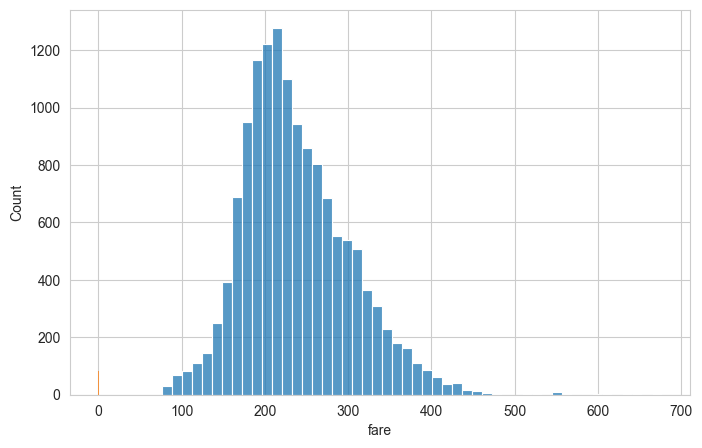

In [8]:
d[["fare","nsmiles","passengers","large_ms","lf_ms"]].describe()
sns.histplot(d["fare"], bins=50)
sns.histplot(d["large_ms"], bins=30)

<Axes: xlabel='nsmiles', ylabel='fare'>

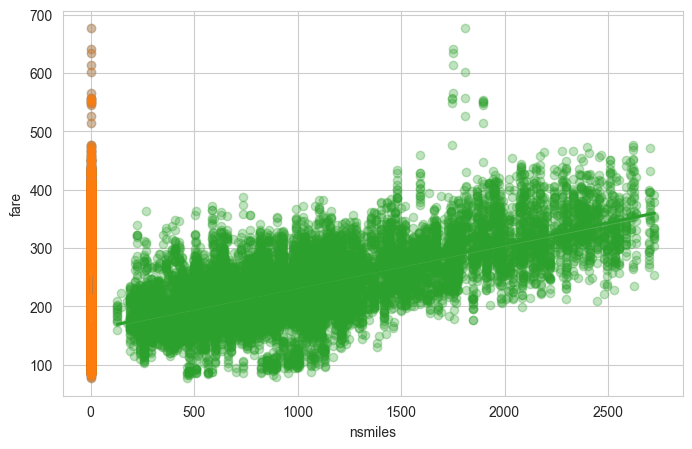

In [9]:
sns.regplot(data=d, x="large_ms", y="fare", scatter_kws={"alpha":0.3})
sns.regplot(data=d, x="lf_ms", y="fare", scatter_kws={"alpha":0.3})
sns.regplot(data=d, x="nsmiles", y="fare", scatter_kws={"alpha":0.3})

<Axes: xlabel='log_fare', ylabel='Count'>

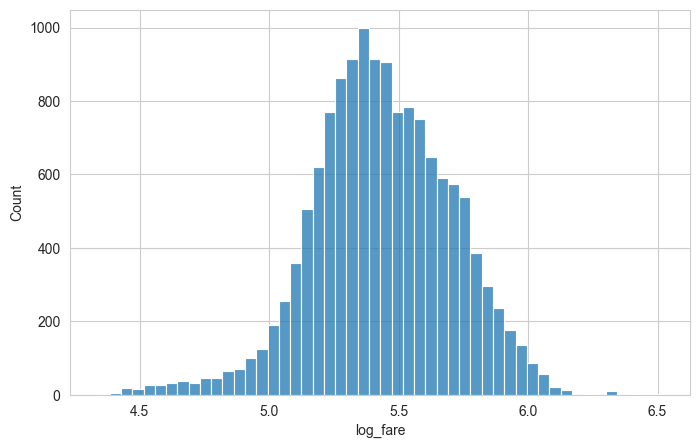

In [10]:
sns.histplot(d["log_fare"], bins=50)

In [11]:
d = d[d["nsmiles"] > 0]
d["log_distance"] = np.log(d["nsmiles"])
d["log_fare"] = np.log(d["fare"])

In [12]:
smf.ols("log_fare ~ log_distance", data=d).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_fare   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     7361.
Date:                Sat, 28 Feb 2026   Prob (F-statistic):               0.00
Time:                        18:33:08   Log-Likelihood:                 1406.2
No. Observations:               14004   AIC:                            -2808.
Df Residuals:                   14002   BIC:                            -2793.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.5980      0.021    167.412      0.000       3.556       3.640
log_distance     0.2699      0.003     85.798      0.000       0.264       0.276
==============================================================================
Omnibus:                     1619.144   Durbin-Watson:                   1.530
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3406.894
Skew:                          -0.723   Prob(JB):                         0.00
Kurtosis:                       4.936   Cond. No.                         81.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Distance explains 34.5% of airfare variation.

That means: 65% of fare variation is driven by:
	Competition
	Demand
	Hub structure
	Time effects
	Market power


In [13]:
m_full = smf.ols(
    "log_fare ~ log_distance + log_passengers + large_ms + lf_ms + hub_intensity + C(Year)",
    data=d
).fit(cov_type="HC3")

m_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_fare   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     1483.
Date:                Sat, 28 Feb 2026   Prob (F-statistic):               0.00
Time:                        18:33:08   Log-Likelihood:                 2619.4
No. Observations:               14004   AIC:                            -5221.
Df Residuals:                   13995   BIC:                            -5153.
Df Model:                           8                                         
Covariance Type:                  HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.1235      0.032    128.918      0.000       4.061       4.186
C(Year)[T.2023]     0.0154      0.005      3.384      0.001       0.006       0.024
C(Year)[T.2024]     0.0288      0.005      6.364      0.000       0.020       0.038
C(Year)[T.2025]     0.0486      0.006      8.547      0.000       0.037       0.060
log_distance        0.2569      0.003     78.482      0.000       0.251       0.263
log_passengers     -0.0622      0.002    -31.638      0.000      -0.066      -0.058
large_ms            0.0841      0.014      5.986      0.000       0.057       0.112
lf_ms              -0.3518      0.011    -32.744      0.000      -0.373      -0.331
hub_intensity       0.0227      0.004      6.426      0.000       0.016       0.030
==============================================================================
Omnibus:                     1219.568   Durbin-Watson:                   1.531
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2160.997
Skew:                          -0.621   Prob(JB):                         0.00
Kurtosis:                       4.469   Cond. No.                         164.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Airfare pricing is driven by cost, competition, and network structure

Distance explains a substantial portion of fare variation (≈35%), but once competition, demand, hub exposure, and time effects are included, explanatory power rises to 45%. This indicates that structural market factors meaningfully shape airfare outcomes.

Routes with higher dominant-carrier market share charge higher prices, while greater low-cost carrier penetration significantly reduces fares. In fact, low-cost competition has a stronger price-reducing effect than dominant share has a price-increasing effect.

Hub exposure also adds pricing power: routes connected to major hubs are systematically more expensive, even after controlling for distance and demand.

Post-pandemic trends show fares rising over time, suggesting structural upward pressure beyond cost fundamentals.

Overall, airfare markets are not purely cost-driven — they reflect measurable market power, competitive dynamics, and network structure.

Our analysis shows that airfares are not primarily driven by distance alone, challenging the common belief that “longer flights simply cost more.” While distance explains about one-third of fare variation, nearly half of pricing differences are explained once competition, hub exposure, demand, and post-pandemic trends are considered. Routes dominated by a single major airline charge systematically higher fares, while greater low-cost carrier presence significantly reduces prices—often by a larger magnitude than dominance increases them. Additionally, hub-to-hub routes carry a measurable pricing premium, suggesting structural network power beyond route-level competition. Together, these findings reveal that affordability is shaped less by geography and more by competitive structure, meaning students and families traveling in less competitive or hub-heavy markets face systemic price disadvantages.

We will be using machine learning next to identify which features are the most predictive, test whether competitive variables exhibit non linear effects, and detect any tipping point where a dominant airline’s market share begins to significantly shift pricing power, and evaluate whether low-cost carrier (LCC) penetration produces a threshold effect where fares drop sharply once presence exceeds a certain level—turning descriptive findings about distance, competition, and hub structure into clear, actionable insights about when and how pricing dynamics change.

In [15]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import matplotlib.pyplot as plt

d = d[(d["fare"] > 0) & (d["nsmiles"] > 0) & (d["passengers"] >= 0)].copy()

if "log_fare" not in d.columns:
    d["log_fare"] = np.log(d["fare"])
if "log_distance" not in d.columns:
    d["log_distance"] = np.log(d["nsmiles"])
if "log_passengers" not in d.columns:
    d["log_passengers"] = np.log(d["passengers"] + 1)


In [16]:
BASE_FEATURES = ["log_distance", "log_passengers", "large_ms", "lf_ms", "hub_intensity"]

X = d[BASE_FEATURES + ["Year"]].copy()
X = pd.get_dummies(X, columns=["Year"], drop_first=True)

y = d["log_fare"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((11203, 8), (2801, 8))

In [18]:
gbr = HistGradientBoostingRegressor(
    max_depth=6,
    learning_rate=0.05,
    max_iter=600,
    l2_regularization=0.0,
    random_state=42
)

gbr.fit(X_train, y_train)

pred = gbr.predict(X_test)

r2 = r2_score(y_test, pred)

mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test, pred)

print(f"R2:  {r2:.3f}")
print(f"RMSE:{rmse:.3f} (log-fare units)")
print(f"MAE: {mae:.3f} (log-fare units)")

R2:  0.746
RMSE:0.134 (log-fare units)
MAE: 0.102 (log-fare units)


In [19]:
perm = permutation_importance(
    gbr, X_test, y_test, n_repeats=10, random_state=42
)

imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
imp.head(15)

log_distance      1.124436
large_ms          0.249945
log_passengers    0.133347
lf_ms             0.101124
hub_intensity     0.027295
Year_2024         0.015261
Year_2025         0.015014
Year_2023         0.005733
dtype: float64

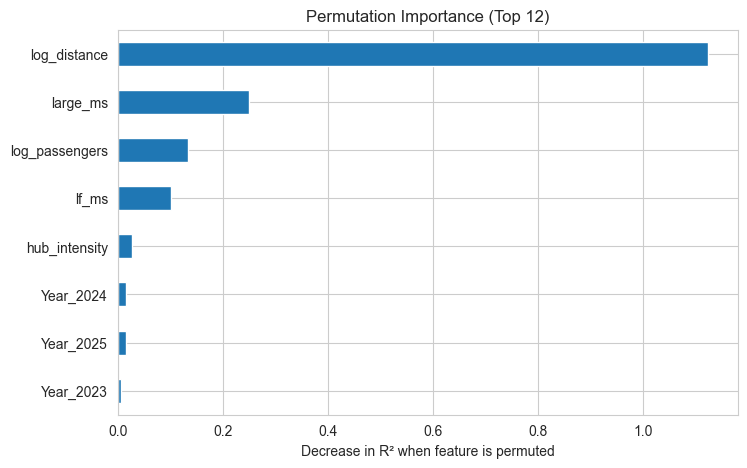

In [20]:
plt.figure()
imp.head(12).sort_values().plot(kind="barh")
plt.title("Permutation Importance (Top 12)")
plt.xlabel("Decrease in R² when feature is permuted")
plt.show()

The permutation importance results show that while distance remains the fundamental cost driver of airfare, market structure plays a powerful and independent role in shaping prices. After controlling for distance and demand, dominant carrier market share is the second most influential predictor of fare levels, indicating that routes with concentrated airline control systematically charge higher prices. Low-cost carrier penetration meaningfully reduces fares, reinforcing the idea that competition, not just geography, drives affordability. Demand matters, but less than market dominance, and hub exposure adds an additional pricing premium. Overall, the model reveals that structural competition explains a substantial portion of airfare variation, highlighting how students and families in dominated or hub-heavy markets face consistent affordability disadvantages.

/Users/carmenteng/SDSS-Datathon/SDSS-Datathon-1/.venv/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:721: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


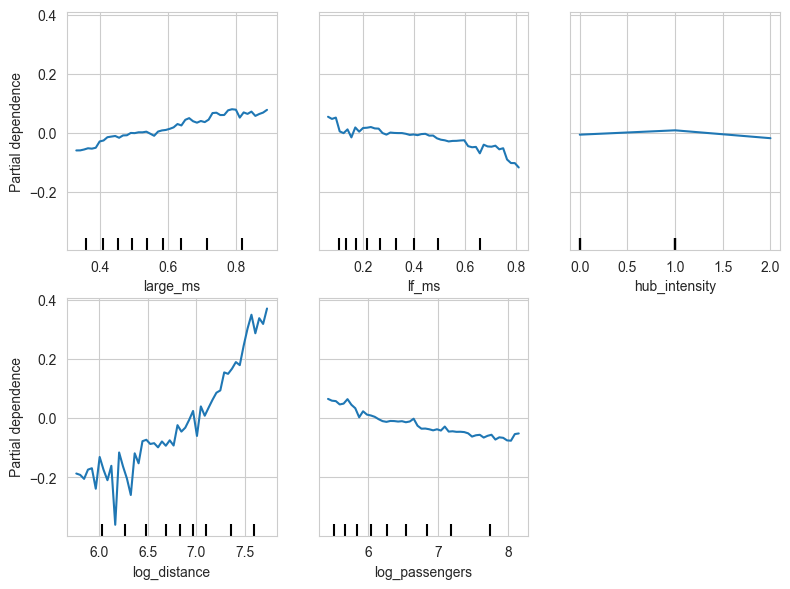

In [21]:
features_for_pdp = ["large_ms", "lf_ms", "hub_intensity", "log_distance", "log_passengers"]

fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(
    gbr, X_test, features=features_for_pdp, grid_resolution=50, ax=ax
)
plt.tight_layout()
plt.show()

These partial dependence plots show how each variable independently shifts predicted log-fare while holding other factors constant. Distance has a strong positive nonlinear effect, confirming that cost increases with length, but the slope steepens at higher distances. Dominant carrier share (large_ms) increases fares steadily, with a sharper upward effect beyond roughly 60–70% market share, suggesting concentrated routes carry pricing premiums. In contrast, low-cost carrier share (lf_ms) reduces fares in a clear downward pattern, reinforcing that competition materially improves affordability. Hub intensity adds a small but consistent premium, while higher passenger volumes slightly reduce fares, likely reflecting economies of density. Overall, the plots confirm that market structure and competition materially shift prices beyond distance alone, supporting the conclusion that structural concentration—not just geography—drives affordability differences.

In [22]:
def prepare_row(route_dict, X_template):
    """
    route_dict includes:
    log_distance, log_passengers, large_ms, lf_ms, hub_intensity, Year
    Returns a single-row dataframe aligned to X columns (with Year dummies).
    """
    row = pd.DataFrame([route_dict])
    row = pd.get_dummies(row, columns=["Year"], drop_first=True)

    row = row.reindex(columns=X_template.columns, fill_value=0)
    return row

def predict_fare(route_dict):
    row = prepare_row(route_dict, X)
    log_pred = gbr.predict(row)[0]
    return float(np.exp(log_pred)) 

In [23]:
baseline = {
    "log_distance": float(d["log_distance"].median()),
    "log_passengers": float(d["log_passengers"].median()),
    "large_ms": float(d["large_ms"].median()),
    "lf_ms": float(d["lf_ms"].median()),
    "hub_intensity": int(d["hub_intensity"].median()),
    "Year": int(d["Year"].mode().iloc[0]),
}

base_fare = predict_fare(baseline)
base_fare

231.9184514659326

In [25]:
sA1 = baseline.copy(); sA1["lf_ms"] = 0.10
sA2 = baseline.copy(); sA2["lf_ms"] = 0.40

fare_10 = predict_fare(sA1)
fare_40 = predict_fare(sA2)

print("Predicted fare at lf_ms=0.10:", round(fare_10,2))
print("Predicted fare at lf_ms=0.40:", round(fare_40,2))
print("Savings ($):", round(fare_10 - fare_40,2))
print("Savings (%):", round((fare_10 - fare_40)/fare_10*100,2))

Predicted fare at lf_ms=0.10: 227.96
Predicted fare at lf_ms=0.40: 230.3
Savings ($): -2.34
Savings (%): -1.03


In [26]:
ols_r2 = 0.449 
print("OLS R²:", ols_r2)
print("Boosting R²:", r2)
print("ΔR²:", r2 - ols_r2)

OLS R²: 0.449
Boosting R²: 0.7455843644652218
ΔR²: 0.2965843644652218


In [ ]:
import joblib

joblib.dump(gbr, "Model/airfare_gbr.joblib")
joblib.dump(list(X.columns), "Model/feature_columns.joblib")
print("Saved model + feature columns.")

In [31]:
import os
import joblib

os.makedirs("Model", exist_ok=True)

joblib.dump(gbr, "Model/airfare_gbr.joblib")
joblib.dump(list(X.columns), "Model/feature_columns.joblib")

print("Saved successfully.")

Saved successfully.
